# CHANNEL MIGRATION ZONE ANALYSIS
### Data Cleaning and Exploratory Data Analysis 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
# Import points
csv = r'/Users/Daniel/Documents/Programming/Project_Scripts/CMZ/data/SouthSaintVrain_points.csv'

df = pd.read_csv(csv, header=0)
# print (df.head())
print (df.info())
print (df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906130 entries, 0 to 906129
Data columns (total 12 columns):
FID                   906130 non-null int64
2011topo              906130 non-null float64
stream_slope          906130 non-null float64
near_crossing         906130 non-null float64
near_road             906130 non-null float64
ground_delta          906130 non-null float64
near_stream           906130 non-null int64
ground_curve          906130 non-null float64
relative_elevation    906130 non-null float64
ground_slope          906130 non-null float64
long_WGS84            906130 non-null float64
lat_WGS84             906130 non-null float64
dtypes: float64(10), int64(2)
memory usage: 83.0 MB
None
                 FID       2011topo   stream_slope  near_crossing  \
count  906130.000000  906130.000000  906130.000000  906130.000000   
mean   453064.500000    5414.232385       1.401222    1055.266465   
std    261577.344049      53.443563       0.289529     878.145913   
min     

Looking at the description of each field, most appear to have a reasonable range of values.  'rel_elev' however has a minimum value of -9999.000000.  That is likely an error in the data processing.  

Without knowing more about these locations, we can't interpret these values or make assumptions about their correct values.  Therefore we'll remove all entries with -9999 for 'rel_elev' field.

In [32]:
# Determine the number of rel_elev observations with suspicious values
print ("%s rows of the data have a 'relative_elevation' value of -9999." %(df[df.relative_elevation ==-9999]['relative_elevation'].count()))
print ("%.2f percent of the total observations will be removed." %(df[df.relative_elevation ==-9999]['relative_elevation'].count()/len(df)*100))
print ('\n')
# Remove these data points as we don't have a defensable method to interpolate this value
df.drop(df[df.relative_elevation == -9999].index, inplace=True)
print (df['relative_elevation'].describe())


0 rows of the data have a 'relative_elevation' value of -9999.
0.00 percent of the total observations will be removed.


count    797021.000000
mean         29.355379
std          42.557130
min          -3.879880
25%           5.372560
50%           7.912600
75%          37.558102
max         267.023987
Name: relative_elevation, dtype: float64


The 'rel_elev' field now has a decent looking quantile. The minimum is still -3.8 (ft).  Given that this field describes a point's elevation relative to the nearest stream, possibly this describes a pond or wetland area.  

We can further investigate the distribution to understand how many negative values remain to make sure it's not an error in the source data.

0.93 percent of the 'relative_elevation' observations are negative.


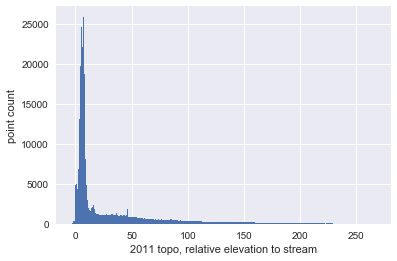

In [6]:
# Calculate what percentage of the values are below 0, or lower than the stream
neg_obs = df[df.relative_elevation < 0]['relative_elevation'].count()
total_obs = len(df)
print ("%.2f percent of the 'relative_elevation' observations are negative." %(neg_obs/total_obs*100))

# Plot the distribution of the 'rel_elev' observations
x = (df['relative_elevation'])
bins = int(np.sqrt(total_obs))
x.hist(bins=bins)
plt.xlabel('2011 topo, relative elevation to stream')
plt.ylabel('point count')
plt.show()

The distribution looks reasonable.  A large number 
of values are clustered around 0 (near the same elevation of the stream), and their is a linear relationship between 
count and relative elevation above ~10 feet.  Remember the data includes areas within 500 feet of the stream, so we're 
likely seeing the hillslope outside of the lower floodplain rising up at a steady slope.  The data is reasonable enough 
to move on to other features.

The target feature of this data analysis is the amount of topography change from 2011 (before the historic floods) to 2013 (after the historic floods).  This value is stored in the 'delta' attribute and represents the value of the 2013 ground surface raster minus the 2011 ground surface raster in cell sizes of 3x3 feet.  The rasters were developed from LiDAR point clouds collected during aerial surveys of the region. (https://oceanservice.noaa.gov/facts/lidar.html).

Let's take a look at the target values before moving on...

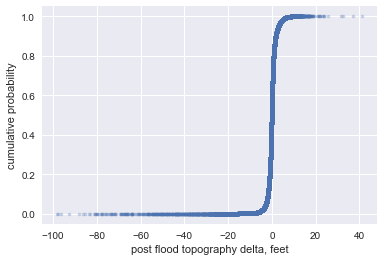

In [7]:
# Lets take a look at the cumulative distribution function of the delta values

# First defining a function to generate the sorted values and ranks.
def ecdf(data): 
    """Compute ECDF for a one-dimensional array of measurements."""
    # Count the number of data points: n
    n = float(len(df))
    # x-data for the ECDF: x sorted from low to high
    x = np.sort(df['ground_delta'])
    # y-data for the ECDF: y as a list of ranks, low to high
    y = np.arange(1,n+1) / n
  
    return x, y

# Call the ecdf function, and generate a plot
x_vers, y_vers = ecdf(df['ground_delta'])
plt.plot(x_vers, y_vers, marker='.', alpha=0.3, linestyle='None')
plt.xlabel('post flood topography delta, feet')
plt.ylabel('cumulative probability')
plt.margins(0.05)


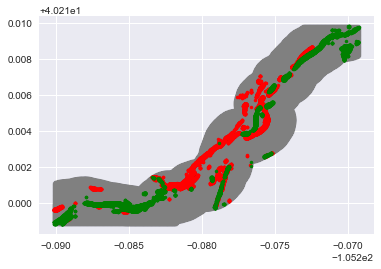

In [8]:
# There's a lot of values concentrated around 0, and long tails both below and above the
# data's center of mass. Let's take a look at the values that are greater than two 
# standard deviations from the mean.

two_std_devs = np.std(df['ground_delta'])*2
mean = np.mean(df['ground_delta'])
neg_outliers = (df[df['ground_delta']<(-1*two_std_devs + mean)])
pos_outliers = (df[df['ground_delta']>(two_std_devs + mean)])
plt.plot(df['long_WGS84'], df['lat_WGS84'], marker='.', color='grey', alpha=0.05, linestyle='None')
plt.plot(neg_outliers['long_WGS84'], neg_outliers['lat_WGS84'], marker='.', color='red', linestyle='None')
plt.plot(pos_outliers['long_WGS84'], pos_outliers['lat_WGS84'], marker='.', color='green', linestyle='None')
plt.show()
# print (neg_outliers.describe())
# plt.show

The plot above has the study area points in the background and colored grey.  The red points are cells with erosion greater than two standard deviations from the mean.  The green are cells with deposition greater than two standard deviations from the mean.  This is the type of map we expect to see, with erosion and deposition around the river corridor.  Although hillslopes might experience minor erosion and deposition, this area is did not experience landslides or major slope failures. 

Is two standard deviations the appropriate cuttoff value for determining areas of channel migration?  We'll need to look at a slice of the data outside of the river corridor to understand the noise associated with the original data collection process

We've taken a sample of data from a nearby area that has no major streams or drainages.  Theoretically, we'd expect almost all cell values to be 0 in this area, showing no sign of topographic change from the flooding event.  

Let's see if the data lives up to that standard. 

In [10]:
# Import the SouthStVrain_nonfppts.csv file (non flooplain pts)

csv = r'/Users/Daniel/Documents/Programming/Project_Scripts/CMZ/data/SouthStVrain_nonfppts.csv'

df_nonfp = pd.read_csv(csv, header=0)
print (df_nonfp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534848 entries, 0 to 534847
Data columns (total 3 columns):
FID          534848 non-null int64
POINTID      534848 non-null int64
GRID_CODE    534848 non-null float64
dtypes: float64(1), int64(2)
memory usage: 12.2 MB
None


[-2.59047607 -0.75488281 -0.47119141 -0.07861328  1.69275634]


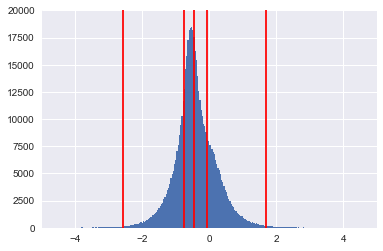

In [22]:
# Specify array of percentiles: percentiles
percentiles = np.array([0.5,25,50,75,99.5])

# Compute percentiles: ptiles_vers
ptiles_vers = np.percentile(df_nonfp['GRID_CODE'],percentiles)
print (ptiles_vers)

bins = int(np.sqrt(len(df_nonfp)))
plt.hist(df_nonfp['GRID_CODE'], bins=bins)

for ptile in ptiles_vers:
    plt.axvline(x=ptile, color='red')
plt.axis([-5,5,0,20000])
plt.show()


# http://www.stat.wmich.edu/s160/book/node46.html

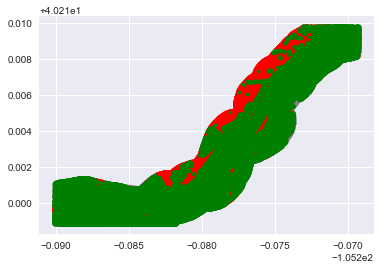

In [23]:
#  Does using eliminating ground delta values between the 25th and 75th percentile work 
#  better than 2 std deviations above and below the mean as cutoff values for noise?
#  Let's map the result to get a feel for it.
neg_outliers = (df[df['ground_delta']< ptiles_vers[1]])
pos_outliers = (df[df['ground_delta']> ptiles_vers[3]])
plt.plot(df['long_WGS84'], df['lat_WGS84'], marker='.', color='grey', alpha=0.05, linestyle='None')
plt.plot(neg_outliers['long_WGS84'], neg_outliers['lat_WGS84'], marker='.', color='red', linestyle='None')
plt.plot(pos_outliers['long_WGS84'], pos_outliers['lat_WGS84'], marker='.', color='green', linestyle='None')
plt.show()


This map of erosion and depostion is not reasonable... there's erosion and deposition over the entire buffer area, despite large areas being outside the floodplain.  

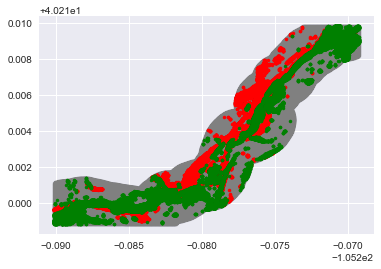

In [24]:
# Lets see how identifying noise as values between the 2.5th percentile and 97.5th 
# percentile looks
neg_outliers = (df[df['ground_delta']< ptiles_vers[0]])
pos_outliers = (df[df['ground_delta']> ptiles_vers[4]])
plt.plot(df['long_WGS84'], df['lat_WGS84'], marker='.', color='grey', alpha=0.05, linestyle='None')
plt.plot(neg_outliers['long_WGS84'], neg_outliers['lat_WGS84'], marker='.', color='red', linestyle='None')
plt.plot(pos_outliers['long_WGS84'], pos_outliers['lat_WGS84'], marker='.', color='green', linestyle='None')
plt.show()

This is looking more reasonable than either the two standard deviation methods or the middle 2 quantile method.  We'll go with the identifying noise as values below the 95th percentile of ground delta values.

The last step of this cleaning step is to export a clean verion of the data to a csv file

In [34]:
# Output CSV of cleaned data
mask = (ptiles_vers[0] < df.ground_delta) & (df.ground_delta < ptiles_vers[4])
column_name = 'ground_delta'
df.loc[mask, 'ground_delta'] = 0

In [35]:
df.to_csv('cmz_points_clean.csv', sep=',', header=True, index=True)
print ('cleaned up data has been written to csv')

cleaned up data has been written to csv
